# Contenuti
- [Scikit-learn](#Scikit-learn)
- [Import delle librerie](#Import-delle-librerie)
- [Dataset](#Dataset)
- [Classificazione](#Classificazione)
    - [k-NN e SVM](#k-NN-e-SVM)
- [Cross-Validation](#Cross-Validation)
- [Grid Search e Cross-Validation](#Grid-Search-e-Cross-Validation)
- [Ottimizzazione iperparametri](#Ottimizzazione-iperparametri)
- [Test](#Test)

# Esercitazione 3
Nell'esercitazione odierna si vedrà come applicare gli algoritmi *k-NN* e *SVM* a un problema di classificazione multiclasse. A tal fine verrà utilizzata la libreria **Scikit-learn**, di cui sarà descritta l'API per l'addestramento e uso di classificatori. Nel corso dell'esercitazione si dovranno individuare le combinazioni di iperparametri che permettono di massimizzare l’accuratezza dei due classificatori sui dataset forniti tramite *Cross-Validation* e *Grid Search*.

Infine si dovrà verificare l'accuratezza della soluzione trovata sul dataset di test per provarne l’effettiva capacità di generalizzazione.

# Scikit-learn
Scikit-learn è una libreria open source per Python che mette a disposizione numerose classi e funzionalità specifiche per il Machine Learning. Oltre a rendere disponibili i più comuni algoritmi per la classificazione, regressione e clustering, sono presenti anche diverse funzionalità per la manipolazione dei dati.

La popolarità di Scikit-learn è dovuta principalmente alla sua facilità d'uso, all'integrazione con la libreria Numpy e alla possibilità di parametrizzare le operazioni messe a disposizione, pur mantenendo una API semplice.

Per una lista completa delle funzionalità si rimanda alla [documentazione ufficiale](http://scikit-learn.org/stable/documentation.html).

# Import delle librerie
Per prima cosa è necessario eseguire l'import delle librerie utilizzate durante l'esecitazione. Il package della libreria Scikit-learn è denominato **sklearn**. Dal package è possibile caricare solamente i moduli necessari.

In [2]:
import pandas as pd
# Moduli di scikit-learn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, ParameterGrid, train_test_split

import ml_utilities
import ml_visualization

# Dataset
Il dataset messo a disposizione consiste in un insieme di cifre (0-9) scritte a mano.
<img src="dataset_resample.png" alt="Processing training set" style="width: 600px;"/>

I dataset di training "pendigits_tr.txt" e "pendigits_tr_Pca_K2.txt" contengono entrambi 442 pattern etichettati (cifre da 0 a 9). Il primo contiene pattern 16-dimensionali (le coordinate x,y di otto punti equispaziati dopo normalizzazione e *resampling*) mentre il secondo consiste in una versione bidimensionale ottenuta tramite riduzione della dimensionalità (mediante l'algoritmo *Principal Component Analysis*), utile per eseguire test iniziali visualizzando pattern e risultati.

Di seguito è fornita la procedura per il caricamento del dataset. È necessario assegnare alla variabile *dataset_path* il percorso dove sono memorizzati i due file. Tramite la variabile *feature_count* è possibile dichiarare quale delle due versioni del dataset si intende utilizzare.

In [22]:
# Scelta del dataset da utilizzare (16 o 2 features)
feature_count = 2
dataset_path = 'DBs/PenDigits/pendigits_tr_Pca_K2.txt'  # Impostare il percorso corretto

# Caricamento del dataset
dataset_patterns, dataset_labels = ml_utilities.load_labeled_dataset_from_txt(dataset_path, feature_count)
print('Shape dataset:', dataset_patterns.shape)
print('Shape labels:', dataset_labels.shape)

Shape dataset: (442, 2)
Shape labels: (442,)


Il dataset caricato può essere suddiviso in due parti: training e validation set. Attraverso il validation set sarà possibile valutare i risultati del classificatore addestrato sul training set al fine di individuare il valore ottimale per gli iperparametri.

Visto che in Machine Learning è comune eseguire tale operazione, la libreria Scikit-learn mette a disposizione una apposita funzione, [**train_test_split(...)**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), che permette di separare un dataset in due parti. 

Il parametro *test_size* descrive la percentuale di pattern che dovrà essere contenuta nella seconda parte. Come configurazione predefinita **train_test_split(...)** mescola i pattern al fine di evitare che i dataset restituiti contengano pattern appartenenti solamente a un sottoinsieme delle classi.

In [75]:
#add shuffle for more randomness
train_x, validation_x, train_y, validation_y = train_test_split(dataset_patterns, dataset_labels, test_size=0.40,shuffle=True)

print('Shape training set:', train_x.shape)
print('Shape validation set:', validation_x.shape)


Shape training set: (265, 2)
Shape validation set: (177, 2)


# Classificazione
Di seguito vengono descritte le operazioni necessarie per creare e addestrare un classificatore. Uno dei punti di forza della libreria Scikit-learn è la sua facilità d'uso e l'uniformità delle chiamate alla libreria: si noti come queste operazioni necessitino solamente di due linee di codice.

In [124]:
# Creazione di un classificatore
dummy_clf = DummyClassifier(strategy='most_frequent')

Nell'esempio, il classificatore creato è un **DummyClassifier** la cui strategia è quella di assegnare ad ogni pattern la classe più numerosa nel training set.

Il classificatore (*estimator* nel lessico di Scikit-learn) può essere addestrato tramite il metodo **.fit(...)** che prende in input un insieme di pattern etichettati X,y. I pattern (X) sono memorizzati per righe in un Numpy array bidimensionale mentre le etichette (y) in un Numpy array monodimensionale.

N.B.: la notazione X (maiuscolo) e y (minuscolo) è normalmente utilizzata in Scikit-learn per indicare un set di pattern (X) e le rispettive etichette (y).

In [126]:
# Addestramento
dummy_clf.fit(train_x, train_y)

DummyClassifier(strategy='most_frequent')

Una volta addestrato, un classificatore può essere utilizzato per riconoscere la classe di uno o più pattern. Per fare ciò, si può utilizzare il metodo **.predict(...)** passando come parametro una lista di pattern. Il risultato che si ottiene è una lista delle label predette dal classificatore.

In [127]:
# Uso della funzione .predict(...)
print('Classi predette:', dummy_clf.predict(validation_x[0:10]))
print('Classi reali:', validation_y[0:10])

Classi predette: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Classi reali: [7. 6. 4. 3. 7. 3. 2. 4. 6. 2.]


In Scikit-learn è possibile misurare l'accuratezza di un classificatore su un determinato dataset richiamando il metodo **.score(...)** che prende in input un insieme di pattern etichettati X,y. Internamente il metodo classifica ogni singolo pattern di X e verifica se l'etichetta assegnata corrisponde alla corrispondente *entry* in y.

In [128]:
# Uso della funzione .score(...)
print('Accuratezza sul training set: %.3f' % dummy_clf.score(train_x, train_y))
print('Accuratezza sul validation set: %.3f' % dummy_clf.score(validation_x, validation_y))

Accuratezza sul training set: 0.147
Accuratezza sul validation set: 0.107


Si implementi la funzione **compute_accuracy(...)** in grado di calcolare l'accuratezza di un classificatore su un insieme di pattern etichettati X,y.

In [130]:
# Esercizio di approfondimento: stima dell'accuratezza
def compute_accuracy(classifier, X, y):
    return  classifier.score(X,y)

print('Accuratezza sul training set: %.3f' % compute_accuracy(dummy_clf, train_x, train_y))
print('Accuratezza sul validation set: %.3f' % compute_accuracy(dummy_clf, validation_x, validation_y))

Accuratezza sul training set: 0.147
Accuratezza sul validation set: 0.107


Per dati bidimensionali può essere utile visualizzare graficamente i pattern e la superfice decisionale del classificatore. Per fare ciò si può utilizzare la funzione **show_2D_results(...)** presente nel modulo ml_visualization.

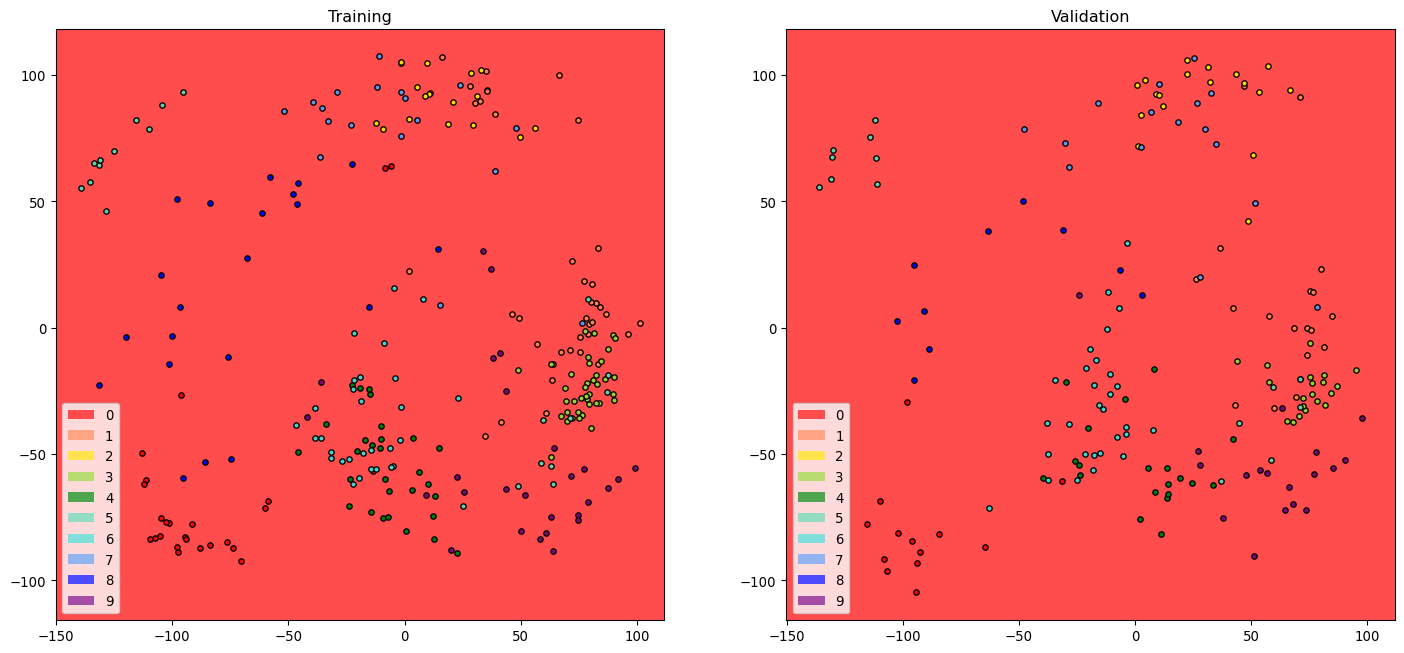

In [131]:
# Uso di show_results
ml_visualization.show_2D_results(dummy_clf, (train_x, train_y, 'Training'), (validation_x, validation_y, 'Validation'))

## k-NN e SVM
Abbiamo visto come, con Scikit-learn, sia possibile creare, addestrare e utilizzare un generico classificatore. Scikit-learn mette a disposizione una serie di classificatori tra cui [k-NN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) e [SVM](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) che utilizzeremo per riconoscere i pattern caricati in precedenza.

Accuratezza KNN
Sul training set: 0.781
Sul validation set: 0.610



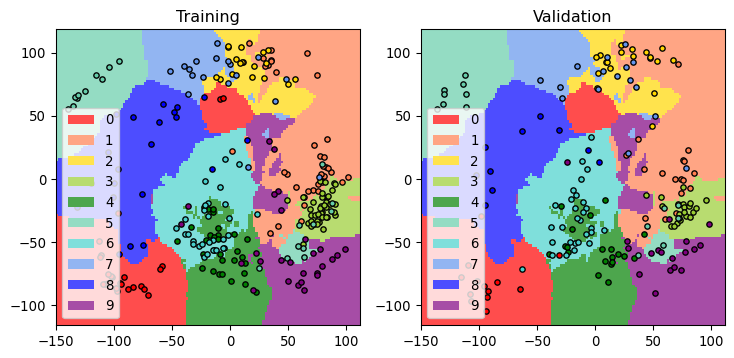

Accuratezza SVC con kernel = linear
Sul training set: 0.611
Sul validation set: 0.548



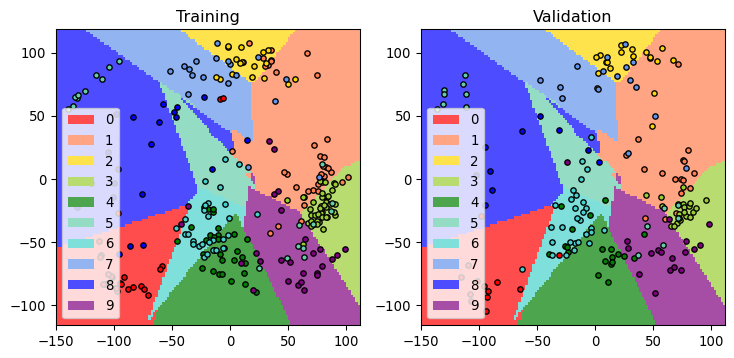

Accuratezza SVC con kernel = rbf
Sul training set: 0.660
Sul validation set: 0.672



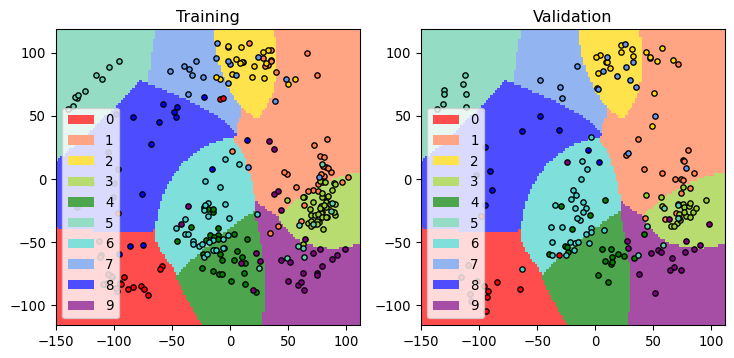

In [165]:
# Esercizio 1: creare ed addestrare un classificatore

clfKNN = KNeighborsClassifier(n_neighbors=5, weights= 'uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski',
                           metric_params=None, n_jobs=None)
clfKNN.fit(train_x,train_y)
# Calcolo accuratezza KNN
print(f"Accuratezza KNN")
print('Sul training set: %.3f' % clfKNN.score(train_x, train_y))
print('Sul validation set: %.3f\n' % clfKNN.score(validation_x, validation_y))
ml_visualization.show_2D_results(clfKNN, (train_x, train_y, 'Training'), (validation_x, validation_y, 'Validation'), figsize=(9, 4))
kernel = ['linear','rbf']
for k in kernel:
    clfSVC = SVC(C=1.0, kernel=k,degree=3,gamma="scale", coef0=0.0, shrinking=True, probability=False, tol=1e-3, cache_size=200,
             class_weight=None,verbose=False,max_iter=-1,decision_function_shape="ovr",break_ties=False, random_state=None)
    clfSVC.fit(train_x,train_y,sample_weight=None)
    # Calcolo accuratezza SVC
    print(f"Accuratezza SVC con kernel = {k}")
    print('Sul training set: %.3f' % clfSVC.score(train_x, train_y))
    print('Sul validation set: %.3f\n' % clfSVC.score(validation_x, validation_y))
    ml_visualization.show_2D_results(clfSVC, (train_x, train_y, 'Training'), (validation_x, validation_y, 'Validation'), figsize=(9, 4))


# Cross-Validation
Se non si vuole riservare un sottoinsieme disgiunto per il validation set e sfruttare tutti i dati disponibili per training e validazione, si può utilizzare la tecnica *Cross-Validation* vista a lezione.  

Si completi il codice nella cella seguente richiamando la funzione [**cross_val_score(...)**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) di Scikit-learn che stima l'accuratezza di un classificatore (*estimator*) tramite *Cross-Validation* (con un numero di *fold* pari a *cv*).

In [172]:
# Esercizio 2: eseguire la Cross Validation utilizzando la funzione cross_val_score
# Reminder: la variabile dataset_patterns include già training e validation set

# Hyperparameter to test = cv..
cv_score = cross_val_score(clfKNN,dataset_patterns,dataset_labels,cv=4)
print('Risultati CrossValidation:\n', cv_score)

Risultati CrossValidation:
 [0.64864865 0.65765766 0.66363636 0.68181818]


# Grid Search e Cross-Validation
Dato un algoritmo, la ricerca degli iperparametri ottimi può essere automatizzata utilizzando, come visto a lezione, la classe [**GridSearchCV**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) messa a disposizione da Scikit-learn.

Questo metodo è particolarmente indicato nei casi in cui l'addestramento di un classificatore non richieda un tempo particolarmente lungo. Si consideri infatti che vengono creati e addestrati $(\textit{# combinazioni degli iperparametri} \times \textit{# fold}) + 1$ classificatori.

Combinazioni di parametri:
 [{'C': 1, 'gamma': 0.05, 'kernel': 'rbf'}, {'C': 1, 'gamma': 0.025, 'kernel': 'rbf'}, {'C': 10, 'gamma': 0.05, 'kernel': 'rbf'}, {'C': 10, 'gamma': 0.025, 'kernel': 'rbf'}]
Accuratezza media per combinazione:
 [0.42292305 0.52098229 0.44181988 0.52098229]
Combinazione migliore:
 {'C': 1, 'gamma': 0.025, 'kernel': 'rbf'}
Accuratezza media della combinazione migliore: 0.521


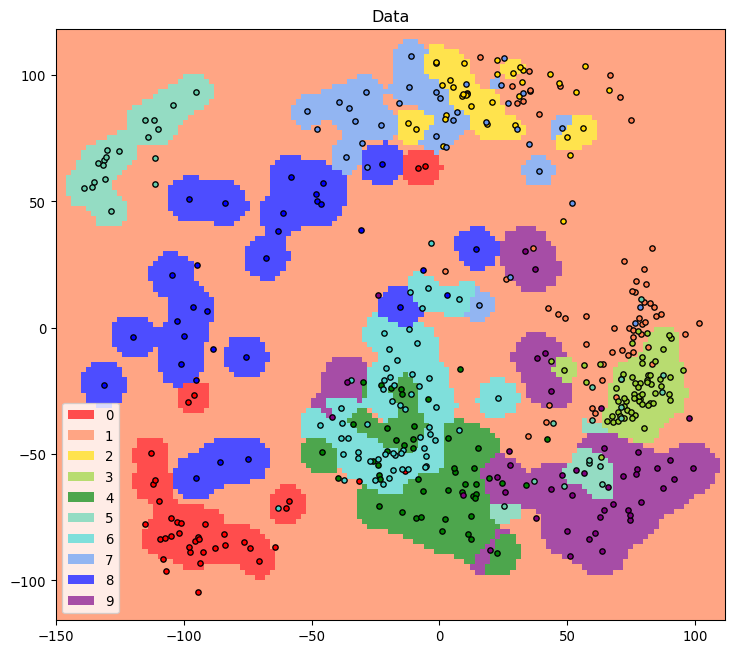

In [174]:
# Creazione di un classificatore di tipo SVM
clf = SVC()

# Creazione della griglia di iperparametri
param_grid = [{'kernel': ['rbf'], 'C': [1,10], 'gamma': [0.05,0.025]}]

# Numero di fold per la Cross-validation
n_folds = 3

# Creazione di un oggetto (modello) di tipo GridSearchCV
grid_search_cv = GridSearchCV(clf, param_grid, cv=n_folds)

# Esecuzione della ricerca degli iperparametri
grid_search_cv.fit(train_x, train_y)

# Stampa risultati
print('Combinazioni di parametri:\n', grid_search_cv.cv_results_['params'])
print('Accuratezza media per combinazione:\n', grid_search_cv.cv_results_['mean_test_score'])
print('Combinazione migliore:\n', grid_search_cv.best_params_)
print('Accuratezza media della combinazione migliore: %.3f' % grid_search_cv.best_score_)

# Visualizzazione 2D
ml_visualization.show_2D_results(grid_search_cv.best_estimator_,
                                 (dataset_patterns, dataset_labels, 'Data'),
                                 figsize=(9, 8))

Se si vuole testare esternamente al **GridSearchCV(...)** i migliori iperparametri precedentemente individuati (*best_params_*), si consiglia di verificarne la bontà utilizzando la funzione **cross_val_score(...)** che restituisce l'accuratezza per le singole _fold_. Viceversa, utilizzando l'intero training set sia per l'addestramento che per la valutazione si rischia di ottenere un valore di accuratezza non realistico. 

In [175]:
# Costruisce un classificatore con i parametri trovati
clf = SVC(**grid_search_cv.best_params_)
print('Classificatore con parametri ottimali:\n', clf, '\n')

# Cross validation
cv_score = cross_val_score(clf, train_x, train_y, cv=n_folds)
print('Accuracy di cross validation: ', cv_score)
print('Accuracy media di cross validation: ', cv_score.mean())

# Addestramento su tutto il dataset
clf = SVC(**grid_search_cv.best_params_)
clf.fit(train_x, train_y)
print('Accuracy classificatore addestrato su tutto il training set:', clf.score(train_x, train_y))

Classificatore con parametri ottimali:
 SVC(C=1, gamma=0.025) 

Accuracy di cross validation:  [0.46067416 0.56818182 0.53409091]
Accuracy media di cross validation:  0.5209822948586994
Accuracy classificatore addestrato su tutto il training set: 0.9169811320754717


# Ottimizzazione iperparametri
Si individui il classificatore (*k-NN* o *SVM*) e la rispettiva combinazione di iperparametri che permettono di massimizzare l'accuratezza sul dataset fornito (16-dimensionale).

Si consiglia di procedere eseguendo **GridSearchCV** su un insieme limitato di combinazioni raffinando la ricerca degli iperparametri in iterazioni successive. In questa maniera sarà possibile ridurre i tempi di attesa.

Nella cella seguente è riportata la procedura per il caricamento del dataset:

In [176]:
# Caricamento del dataset
feature_count = 16
dataset_path = 'DBs/PenDigits/pendigits_tr.txt'  # Impostare il percorso corretto

dataset_patterns, dataset_labels = ml_utilities.load_labeled_dataset_from_txt(dataset_path, feature_count)

Utilizzando il dataset appena caricato si identifichi una combinazione di iperparametri ottimi. A tal fine nella cella seguente è possibile sperimentare le tecniche viste in questa esercitazione.

In [ ]:
# Esercizio 3: ottimizzazione Iperparametri
# ragionare sullo splitting del test e validation, provare più alternative (provare con lo stratificato)
# inizializzazione KNN con opportuni parametri
# creazione param_grid per KNN

# inizializzazione SVC con opportuni parametri
# creazione param_grid per SVC

# selezionare numero di fold

# creazione GridSearch per KNN e SV
# esecuzione del fitting per tutti e due
# stampare risultati (combinazione migliore + accuratezza, accuratezza media)



# Test
Si addestri il classificatore desiderato utilizzando gli iperparametri trovati nell'esercizio precedente. Il codice contenuto nella cella seguente userà tale classificatore per predire la classe dei pattern del dataset di test. Le classi predette verranno salvate su un file di testo che dovrà essere caricato sul sito della competizione per misurarne l'accuratezza.

Il file "pendigits_te.txt" contiene 5000 pattern 16-dimensionali non etichettati.

Sul sito della competizione dovrà essere caricato uno zip contenente sia il file di testo "Es3Predictions.txt" che una cartella "Codice" contenente il codice (notebook e script) da utilizzare per replicare il risultato.

Nota: all'interno dello zip il file "Es3Predictions.txt" non deve essere contenuto in una cartella.

In [ ]:
# Esercizio 4: valutazione su test set

result_path = 'Es3Predictions.txt'

# Caricamento del dataset
feature_count = 16
test_path = 'DBs/PenDigits/pendigits_te.txt'

test_x = ml_utilities.load_unlabeled_dataset_from_txt(test_path, feature_count)

# Creazione del classificatore
### inserimento del miglior classificatore trovato ###
clf = ...

# Addestramento del classificatore
clf.fit(dataset_patterns, dataset_labels)

# Calcolo delle prediction
predictions = clf.predict(test_x)

# Salvataggio delle prediction
with open(result_path, "w") as f:
    for prediction in predictions:
        f.write(str(int(prediction)) + '\n')
print('Salvataggio delle prediction riuscito')